#  <font color='black'>Setting up</font>

##  <font color=#399FD5>Collapsible Headings</font>

Run the following commands in anaconda prompt to install a graphical interface for configuring collapsible headings and other extentions/plugins from within the notebooks:

pip install jupyter_contrib_nbextensions

jupyter contrib nbextension install --user

jupyter nbextensions_configurator enable --user

Once done, go to Jupyter notebook --> Nbextensions --> check the "Collapsible Headings" box

## <font color=#399FD5>Imports</font>

In [1]:
from tkinter import Tk
from tkinter import filedialog # for prompting user to set analysis folder
import glob
import json
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import scipy

## <font color=#399FD5>Suppress Warnings</font>

In [2]:
import warnings
warnings.filterwarnings('ignore')

## <font color=#399FD5>Constants</font>

In [3]:
ABSORPTION_LIMIT = 5.0
SPECIAL_CHARACTERS = "!@#$%^&*()-+?_=,<>/"

# Lithium constants
mLi6 = 0
Li6D2Gamma = 5.8724 # MHz
Li6D2lambda0 = 670.977338*10**(-9) # meters
Li6D2sigma0 = 3*(Li6D2lambda0)**2/(2*np.pi)

# Convenience functions

## <font color=#399FD5>Construct file paths</font>

In [21]:
# construct file fullpath from folder_path and run_id

def construct_file_fullpath(folder_path, run_id = 'something random'):
    files_fullpath = sorted(glob.glob(folder_path + '/*.fits'))
    current_file_fullpath = files_fullpath[0]
    for f in files_fullpath:
        if run_id in f:
            current_file_fullpath = f
    return current_file_fullpath

## <font color=#399FD5>Get run parameters</font>

In [24]:
def get_run_param_from_filename(folder_path, current_file_fullpath, param):
    '''
    get a single parameter value from a file
    '''
    param_for_filename = 0 
    metadata_fullpath = folder_path + "/run_params_dump.json"
    with open(metadata_fullpath, 'r') as json_file:
        metadata_dict = json.load(json_file)  
    name = str(current_file_fullpath.split(folder_path)[1]).replace('\\',"")
    run_id = name.split('_')[0] 
    run_id = "".join(ch for ch in run_id if ch.isalnum() ) # extract run_id out of folder name
    # get params for this run_id
    params_for_run_id = metadata_dict[run_id]    
    param_for_filename = params_for_run_id[param]
    
    return param_for_filename

In [22]:
# for each folder, get list of run parameters
def get_run_params(folder_path, params):
    '''
    params: list
    '''
    params_for_folder = [] # this is a list of dictionaries
    metadata_fullpath = folder_path + "/run_params_dump.json"
    with open(metadata_fullpath, 'r') as json_file:
        metadata_dict = json.load(json_file)  
    for f in sorted(glob.glob(folder_path + '/*.fits')): # for every fits file in folder
        name = str(f.split(folder_path)[1]).replace('\\',"")
        run_id = name.split('_')[0] 
        run_id = "".join(ch for ch in run_id if ch.isalnum() )
        # get params for this run_id
        params_for_run_id = metadata_dict[run_id]    
        param_dict = dict()
        for param in params:
            param_dict[param] = params_for_run_id[param]
        params_for_folder.append(param_dict)
    return params_for_folder

### EXAMPLE CODE: ####
# params = get_run_params(folder_path, params = ['LFImgFreq', 'SideGreenEvap', 'IREvap'])

## <font color=#399FD5>Display image</font>

In [7]:
# function for safely handling subtractions...
# Credit: Eric A. Wolf, BEC1@MIT, 2022. 

def safe_subtract(x, y, minimum_cast = np.byte):
    newtype = np.result_type(x, y, minimum_cast)
    return x.astype(newtype) - y.astype(newtype)

In [8]:
# display an image given folder_path, run_id, ROI, and frame_type:
def display_image(current_file_fullpath, ROI, norm_box, 
                  frame_type = 'FakeOD', min_scale=0, max_scale=1.3, brightness=12):
    # set up figure
    fig, ax = plt.subplots()
    
    # read image
    fits_image = fits.open(current_file_fullpath)
    # fits_image.info() # display fits image info
    img = fits_image[0].data
    fits_image.close()

    # get dims of image
    dims = img[0,:,:].shape 
    x_limit = dims[1]
    y_limit = dims[0]

    # then show image:
    if frame_type == 'OD':
        frame = (-np.log(safe_subtract(img[0,:,:], img[2,:,:])/safe_subtract(img[1,:,:], img[2,:,:])))
        # clean image: using nan_to_num
        frame = np.nan_to_num(frame, nan=ABSORPTION_LIMIT)
        # fix clipping
        frame = np.clip(frame, 0, ABSORPTION_LIMIT)
        ax.imshow(frame, cmap='gray', vmin=0, vmax=2**15).set_clim(min_scale, max_scale)
        ax.invert_yaxis()

    else:
        if frame_type == 'FakeOD':
            frame = (safe_subtract(img[0,:,:], img[2,:,:])/safe_subtract(img[1,:,:], img[2,:,:]))
            # clean image: using nan_to_num
            frame = np.nan_to_num(frame)
            # fix clipping
            frame = np.clip(frame, 0, ABSORPTION_LIMIT)
            ax.imshow(frame, cmap='gray', vmin=0, vmax=2**15).set_clim(min_scale, max_scale)
            ax.invert_yaxis()
        else:
            if frame_type == 'With atoms':
                frame = img[0,:,:]
                # clean image: using nan_to_num
                frame = np.nan_to_num(frame)
                ax.imshow(frame, cmap='gray', vmin=0, vmax=2**brightness)  # need to adjust gray scale/colormap here with BRIGHTNESS variable
                ax.invert_yaxis()
            elif frame_type == 'Without atoms':
                frame = img[1,:,:]
                # clean image: using nan_to_num
                frame = np.nan_to_num(frame)
                ax.imshow(frame, cmap='gray', vmin=0, vmax=2**brightness)  # need to adjust gray scale/colormap here with BRIGHTNESS variable
                ax.invert_yaxis()
            elif frame_type == 'Dark':
                frame = img[2,:,:]
                # clean image: using nan_to_num
                frame = np.nan_to_num(frame)
                ax.imshow(frame, cmap='gray', vmin=0, vmax=2**brightness)  # need to adjust gray scale/colormap here with BRIGHTNESS variable
                ax.invert_yaxis()
            else:
                frame = (-np.log(safe_subtract(img[0,:,:], img[2,:,:])/safe_subtract(img[1,:,:], img[2,:,:])))
                # clean image: using nan_to_num
                frame = np.nan_to_num(frame)
                ax.imshow(frame, cmap='gray', vmin=0, vmax=2**15).set_clim(min_scale, max_scale)
                ax.invert_yaxis()
                
    # Create a roi patch
    width = abs(int(ROI[1]) - int(ROI[0]))
    height = abs(int(ROI[3]) - int(ROI[2]))
    xmin = min(int(ROI[0]), int(ROI[1]))
    ymin = min(int(ROI[2]), int(ROI[3]))
    roi = patches.Rectangle((xmin, ymin), 
                             width, 
                             height, 
                             linewidth=1, 
                             edgecolor='r', 
                             facecolor='none')
    # Add the ROI to the Axes
    ax.add_patch(roi)
    
    # Create a norm_box patch
    width_norm = abs(int(norm_box[1]) - int(norm_box[0]))
    height_norm = abs(int(norm_box[3]) - int(norm_box[2]))
    xmin_norm = min(int(norm_box[0]), int(norm_box[1]))
    ymin_norm = min(int(norm_box[2]), int(norm_box[3]))
    
    norm_roi = patches.Rectangle((xmin_norm, ymin_norm), 
                             width_norm, 
                             height_norm, 
                             linewidth=1, 
                             edgecolor='g', 
                             facecolor='none')
    # Add the ROI to the Axes
    ax.add_patch(roi)
    ax.add_patch(norm_roi)   
    # show everything
    plt.show()
                
    return (fig, ax)

## <font color=#399FD5>Pixel summing</font>

In [197]:
def get_pixel_sum_single_image(current_file_fullpath, ROI, norm_box):
    # read image
    fits_image = fits.open(current_file_fullpath)
    img = fits_image[0].data
    fits_image.close()

    # get od image, crop, and sum
    od = (-np.log(safe_subtract(img[0,:,:], img[2,:,:])/safe_subtract(img[1,:,:], img[2,:,:])))
    # now clean od:
    od = np.nan_to_num(od)
    # fix clipping
    od = np.clip(od, 0, ABSORPTION_LIMIT)
    od = od.astype(np.float)
    od_cropped = od[ROI[2]:ROI[3], ROI[0]:ROI[1]] # just OD, but cropped
    norm_od = od[norm_box[2]:norm_box[3], norm_box[0]:norm_box[1]]
    
    od_cropped_area = abs(ROI[3] - ROI[2])*abs(ROI[1] - ROI[0])
    norm_od_area = abs(norm_box[3] - norm_box[2])*abs(norm_box[1] - norm_box[0])
    
    return sum(sum(od_cropped)) - sum(sum(norm_od*od_cropped_area/norm_od_area))

In [10]:
def get_pixel_sum_folder(folder_path, ROI, norm_box, filename_key = '', param = 'id'):
    pixel_sums = []
    param_list = []
    image_list = sorted(glob.glob(folder_path + '/*.fits'))
    for f in image_list:
        if filename_key == '' or filename_key in f:
            pixel_sums.append(get_pixel_sum_single_image(f, ROI, norm_box))
            # now get param list associated with these pixel sums:
            param_list.append(get_run_param_from_filename(folder_path, f, param))
        print('Progress: ' + str(image_list.index(f) + 1) + '/' + str(len(image_list)))
    pixel_sums = np.array(pixel_sums)
    param_list = np.array(param_list)
    
    return pixel_sums, param_list

In [20]:
def get_pixel_sums_folder_TopAB(folder_path, ROI, norm_box, param_A = 'id', param_B = 'id'):
    pixel_sums_A = []
    pixel_sums_B = []
    param_list_A = []
    param_list_B = []
    image_list = sorted(glob.glob(folder_path + '/*.fits'))        
    for f in image_list:
        if 'TopA' in f:
            pixel_sums_A.append(get_pixel_sum_single_image(f, ROI, norm_box))
            param_list_A.append(get_run_param_from_filename(folder_path, f, param_A))
        elif 'TopB' in f:
            pixel_sums_B.append(get_pixel_sum_single_image(f, ROI, norm_box))
            param_list_B.append(get_run_param_from_filename(folder_path, f, param_B))            
        print('Progress: ' + str(image_list.index(f) + 1) + '/' + str(len(image_list)))
        
    pixel_sums_A = np.array(pixel_sums_A)
    pixel_sums_B = np.array(pixel_sums_B)
    param_list_A = np.array(param_list_A)
    param_list_B = np.array(param_list_B)
    
    return pixel_sums_A, param_list_A, pixel_sums_B, param_list_B

## <font color=#399FD5>Get atom densities from absorption images</font>

Some theory for atom counting. The 2D atom density, including the effect of saturation, is given by 

$n_{2d}(x,y) = \int n_{3d}(x,y,z)\,dz = -\frac{1+I/I_\text{sat}(\omega)}{\sigma(\omega)} \ln \frac{I_f}{I_0} = \frac{1+s\sigma(\omega)/\sigma_0}{\sigma(\omega)} \times \text{OD}, $ 

where $\kappa(\omega, I) = \frac{n_{2d} \sigma(\omega)}{1 + I / I_\text{sat}(\omega)}$ is the absorption coefficient, 
$\sigma(\omega) = \sigma_0 \frac{\Gamma^2/4}{(\omega-\omega_0)^2 + \Gamma^2/4}$, and $\sigma_0 = \frac{3\lambda_0^2}{2\pi}$.

So, after the fit has been done, we know $\omega_0$ and $s$. Since $\sigma_0$ is known, we can calculate $(1+s \sigma(\omega)/\sigma_0)/\sigma(\omega)$ for every shot. From here, we can obtain $n_{2d}$ from knowing the OD (which comes from the image). Finally, to obtain the atom number, we just multiply the atom density $n_{2d}$ by the pixel size and integrate over the entire image to get $N$. 

Notice that we have not considered the fact that for (nearly) blacked out clouds the saturation parameter changes as a function of the line of integration. How might we take this into account? Consider the Beer-Lambert law, which says 

$ \frac{dI}{I} = -\kappa(I, \omega) \,dz = -n\sigma_0 \frac{\Gamma^2/4}{\delta^2 + (1+s)\Gamma^2/4} \,dz \implies \int_{s_0}^{s_f} \frac{1}{s} \frac{\Gamma^2/4}{\delta^2 + (1+s)\Gamma^2/4} \,ds =  -n_{2d}\sigma_0 $.

where we have made the substitution $I \to s I_\text{sat},  I_0 \to s_0 I_\text{sat}, I_f \to s_f I_\text{sat}$ and integrated both sides, simplifying the integrand, we find that

$-n_{2d} \sigma_0 =  \int_{s_0}^{s_f} 1 + \frac{1 + 4\delta^2/\Gamma^2}{s}\,ds = (s_f - s_0) + \left( 1 + \frac{4\delta^2}{\Gamma^2} \right)\ln \frac{s_f}{s_0}.$

From here, the atom density is readily found:

$\boxed{n_{2d} = -\frac{1}{\sigma_0} \left[ \left( 1 + \frac{4\delta^2}{\Gamma^2} \right) \ln \frac{I_f}{I_0} +  \frac{I_f - I_0}{I_\text{sat}}\right] =  \frac{1}{\sigma_0} \left( 1 + \frac{4\delta^2}{\Gamma^2} \right) \times od  -\frac{1}{\sigma_0} \frac{I_f - I_0}{I_\text{sat}} = \frac{od}{\sigma(\omega)}  -\frac{1}{\sigma_0} \frac{I_f - I_0}{I_\text{sat}} } $

One final thing: how do we obtain $I_\text{sat}$? There are several ways to do this, but one way is to obtain the saturation parameter $s$ from the imaging resonance curve fit, and then take the without atom shot and divide it by $s$ to get an approximation for $I_\text{sat}$.

In [12]:
def get_density_abs_single_image(current_file_fullpath, ROI, norm_box, sigma0, sigma, s):
    # read image
    fits_image = fits.open(current_file_fullpath)
    img = fits_image[0].data
    fits_image.close()

    # get od image, crop, and sum
    od = (-np.log(safe_subtract(img[0,:,:], img[2,:,:])/safe_subtract(img[1,:,:], img[2,:,:])))
    # now clean od
    od = np.nan_to_num(od)
    # fix clipping
    od = np.clip(od, 0, ABSORPTION_LIMIT)
    od = od.astype(np.float)
    od_cropped = od[ROI[2]:ROI[3], ROI[0]:ROI[1]] # just OD, but cropped
    
    # Isat will be approimately the Intensity WOA divided by saturation parameter s
    Isat = img[1,:,:].astype(np.float)/s
    
    # ic is (WA - WOA)/Isat/sigma0
    ic = (safe_subtract(img[0,:,:], img[1,:,:])/Isat)/sigma0
    ic = np.nan_to_num(ic)
    ic_cropped = ic[ROI[2]:ROI[3], ROI[0]:ROI[1]] # just ic, but cropped
    
    # n2D = od/sigma(omega), naively, assuming saturation is constant across the cloud
    n2D = od_cropped/sigma - ic_cropped
    
    return n2D

In [13]:
def get_densities_abs_folder(folder_path, ROI, norm_box, s, sigma0, omega_name , omega0, gamma, AOM_factor):
    '''
    omega0 shoud be of the form LFImgFreq * AOM_factor
    typically, omega0 is just going to be the center of the fit
    '''
    n2D_list = []
    omegas_dict_list = get_run_params(folder_path, params = ['LFImgFreq'])
    omegas = []
    for omegas_dict in omegas_dict_list:
        omegas.append(omegas_dict[omega_name])
    omegas = np.array(omegas)
    omegas = omegas*AOM_factor
    image_list = sorted(glob.glob(folder_path + '/*.fits'))
    
    # image_list and omegas should always have the same length
    for f in range(len(image_list)):
        # calculate sigma(omega)
        sigma = sigma0*(gamma**2/4)/( (omega0 - omegas[f])**2 + gamma**2/4 )
        n2D_list.append(get_density_abs_single_image(image_list[f], ROI, norm_box, sigma0, sigma, s))
    
    return n2D_list    

In [41]:
def get_densities_abs_folder_TopAB(folder_path, ROI, norm_box, 
                                   s_A = 0.0, s_B = 0.0, sigma0 = Li6D2sigma0, 
                                   img_freq_A = 'ImagFreq1', img_freq_B = 'ImagFreq2', 
                                   omega0_A = 0, omega0_B = 0, gamma = Li6D2Gamma, AOM_factor = -2,
                                   param_A = 'ImagFreq1', param_B = 'ImagFreq2'):
    
    n2d_A = []
    n2d_B = []
    img_freqs_A = []
    img_freqs_B = []
    param_list_A = []
    param_list_B = []
    image_list = sorted(glob.glob(folder_path + '/*.fits'))
    
    for f in image_list:
        if 'TopA' in f:
            omega = get_run_param_from_filename(folder_path, f, img_freq_A)*AOM_factor
            sigma = sigma0*(gamma**2/4)/( (omega0_A - omega)**2 + gamma**2/4 )
            n2d_A.append(get_density_abs_single_image(f, ROI, norm_box, sigma0, 
                                                      sigma, s_A))
            img_freqs_A.append(omega)
            param_list_A.append(get_run_param_from_filename(folder_path, f, param_A))
            
        elif 'TopB' in f:
            omega = get_run_param_from_filename(folder_path, f, img_freq_B)*AOM_factor
            sigma = sigma0*(gamma**2/4)/( (omega0_B - omega)**2 + gamma**2/4 )
            n2d_B.append(get_density_abs_single_image(f, ROI, norm_box, sigma0, 
                                                      sigma, s_B))
            img_freqs_B.append(omega)
            param_list_B.append(get_run_param_from_filename(folder_path, f, param_B))
            
        print('Progress: ' + str(image_list.index(f) + 1) + '/' + str(len(image_list)))
    
    return n2d_A, img_freqs_A, n2d_B, img_freqs_B, param_list_A, param_list_B

## <font color=#399FD5>Mathematical functions</font>

In [55]:
def _absorption_coefficient(omega, amp, omega0, gamma_prime, offset):
    return amp * gamma_prime**2/ ( 4*(omega-omega0)**2 + gamma_prime**2) + offset

In [233]:
def _P2_Rabi(omega_and_tau, omegaR, omega0):
    omega = omega_and_tau[0]
    tau = omega_and_tau[1]    
    OmegaR = np.sqrt(omegaR**2 / (omegaR**2 + (omega - omega0)**2))
    return ( omegaR**2 / OmegaR**2) * np.sin( 2*np.pi*OmegaR * tau * 10**(6-3)/ 2)**2

## <font color=#399FD5>Fit functions</font>

### <font color='6C828D'>Li resonance imaging curve fit</font>

In [118]:
def Li_resonance_imaging_curve_fit(freqs, 
                                   pixel_sums, 
                                   AOM_factor,
                                   center_guess, 
                                   plot_xlabel = 'ImagFreq1 x AOM_Factor',
                                   plot_title = 'Resonance Curve'):
    
    # get guesses from experiment_parameters_dict and known constants
    center_guess = center_guess*AOM_factor 
    gamma_prime_guess = Li6D2Gamma # from table of constants
    amplitude_guess = max(pixel_sums)
    offset_guess = min(pixel_sums)/10

    # fit
    freqs_fit = freqs*AOM_factor
    params_lorzt, covariance_lorzt = scipy.optimize.curve_fit(_absorption_coefficient, freqs_fit, pixel_sums, 
                                                              p0=[amplitude_guess, center_guess, 
                                                                  gamma_prime_guess, offset_guess],
                                                              bounds = ([0, -np.inf, 0, 0],
                                                                       [np.inf, np.inf, np.inf, np.inf]))
    errors_lorzt = np.sqrt(np.diag(covariance_lorzt))

    # get fit parameters
    amplitude = params_lorzt[0]
    center = params_lorzt[1]
    gamma_prime = params_lorzt[2]
    offset = params_lorzt[3]

    # get fit parameter errors
    amplitude_error = errors_lorzt[0]
    center_error = errors_lorzt[1]
    gamma_prime_error = errors_lorzt[2]
    offset_error = errors_lorzt[3]

    # make fitted curve
    freqs_fit_plot = np.linspace(min(freqs)*AOM_factor, max(freqs)*AOM_factor, len(freqs)*10)
    pixel_sums_fit = amplitude*gamma_prime**2/ ( 4*(freqs_fit_plot-center)**2 + gamma_prime**2) + offset

    # print out fit results
    print('----------Fit result----------------')
    print('Amplitude: ' + str('{:.2f}'.format(amplitude)) + ' +/- ' + str('{:.2f}'.format(amplitude_error)))
    print('Center: ' + str('{:.2f}'.format(center)) + ' +/- ' + str('{:.2f}'.format(center_error)))
    print('Gamma prime: ' + str('{:.2f}'.format(gamma_prime)) + ' +/- ' + str('{:.2f}'.format(gamma_prime_error)))
    print('Offset: ' + str('{:.2f}'.format(offset)) + ' +/- ' + str('{:.2f}'.format(offset_error)))
    print('Calculated saturation parameter: ' + str('{:.2f}'.format((gamma_prime/Li6D2Gamma)**2 - 1)))

    # print resonance value in Cicero space:
    print('------------------------------------')
    print('Set value in Cicero to: ' + str('{:.2f}'.format(-center/2)))

    # plotting 
    plt.scatter(freqs_fit, pixel_sums, color = 'black', )
    plt.plot(freqs_fit_plot, pixel_sums_fit, color='red', linewidth=1)
    plt.xlabel(plot_xlabel)
    plt.ylabel('Pixel sum')
    plt.title(plot_title)
    plt.show()
    
    # return results
    fit_result = dict()
    fit_result['amplitude'] = amplitude
    fit_result['center'] = center
    fit_result['gamma prime'] = gamma_prime
    fit_result['offset'] = offset
    fit_result['calculated saturation parameter'] = (gamma_prime/Li6D2Gamma)**2 - 1
    
    return fit_result

### <font color='6C828D'>RF resonance curve fit</font>

In [239]:
def Li_P2_Rabi_RF_curve_fit(RF_freqs_and_taus, 
                            RF_transfers, 
                            omega0_guess = 75,
                            omegaR_guess = 1, 
                            plot_xlabel = 'RF frequency',
                            plot_title = 'RF Resonance Curve'):
    
    # generate guesses:
    offset_guess = 0
    
    # fit
    params_Rabi, covariance_Rabi = scipy.optimize.curve_fit(_P2_Rabi, 
                                                              xdata = RF_freqs_and_taus, 
                                                              ydata = RF_transfers, 
                                                              p0 = [omegaR_guess, omega0_guess],
                                                              bounds = ([0, omega0_guess*0.9],
                                                                       [np.inf, omega0_guess*1.1]))
    errors_Rabi = np.sqrt(np.diag(covariance_Rabi))
    
    # get fit parameters
    #omegaR = params_Rabi[0]
    #omega0 = params_Rabi[1]
    #offset = params_Rabi[2]
    
    # test
    omegaR = 0.0004
    omega0 = omega0_guess
    #offset = 0
    
    # make fitted curve
    RF_freqs_fit_plot = np.linspace(min(RF_freqs_and_taus[0]), max(RF_freqs_and_taus[0]), len(RF_freqs_and_taus[0])*10)
    taus_fit_plot = np.linspace(min(RF_freqs_and_taus[1]), max(RF_freqs_and_taus[1]), len(RF_freqs_and_taus[1])*10)
    OmegaR = np.sqrt(omegaR**2 + (RF_freqs_fit_plot - omega0)**2)
    RF_transfer_fit = (omegaR**2 / OmegaR**2) * np.sin(2*np.pi*OmegaR * taus_fit_plot * 10**(6-3) / 2)**2 
    
    # plotting 
    plt.scatter(RF_freqs_and_taus[0], RF_transfers, color = 'black', )
    plt.plot(RF_freqs_fit_plot, RF_transfer_fit, color='red', linewidth=1)
    plt.xlabel(plot_xlabel)
    plt.ylabel('RF Transfer B/(A+B)')
    plt.title(plot_title)
    plt.show()
    
    fit_result = dict()
    fit_result['omegaR'] = omegaR
    fit_result['center'] = omega0
    #fit_result['offset'] = offset
    
    return fit_result

## <font color=#399FD5>Data filter</font>

In [264]:
def generic_data_filter(x_data, y_data, tolerance):
    '''
    x_data: np.array()
    y_data: np.array()
    assumes len(x_data) == len(y_data)
    tolerance: float, how many st devs is the cutoff
    compute the standard deviation of y_data
    removes y_data points beyond tolerance and corresponding x_data
    return filtered_x_data, filter_y_data
    '''
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    
    filtered_x_data = np.array([])
    filtered_y_data = np.array([])
    
    if len(x_data) == len(y_data):
        st_dev_y_data  = np.std(y_data)
        mean_y_data = np.average(y_data)
        for i in range(len(x_data)):
            if y_data[i] < mean_y_data + tolerance*st_dev_y_data and y_data[i] > mean_y_data - tolerance*st_dev_y_data:
                filtered_x_data = np.append(filtered_x_data, x_data[i])
                filtered_y_data = np.append(filtered_y_data, y_data[i])
    else:
        print('Incompatible sizes!')
        return [],[]
    
    return filtered_x_data, filtered_y_data

# Na Catch

# Na BEC

## <font color=#399FD5>Data preview and preparation</font>

In [ ]:
# select folder
folder_path_BEC = filedialog.askdirectory()
print('Current folder: ' + folder_path_BEC)

# print out all files:
for f in glob.glob(folder_path_BEC + '/*.fits'): # for every fits file in folder
    name = str(f.split(folder_path_BEC)[1]).replace('\\',"")
    print(name)

# load metadata if avalable:
metadata_fullpath_BEC = folder_path_BEC + "/run_params_dump.json"
if os.path.isfile(metadata_fullpath_BEC):
    with open(metadata_fullpath_BEC, 'r') as json_file:
        metadata_dict_BEC = json.load(json_file)  
        
# load experiment_parameters if avaiable:
experiment_parameters_fullpath_BEC = folder_path_BEC + "/experiment_parameters.json"
if os.path.isfile(experiment_parameters_fullpath_BEC):
    with open(experiment_parameters_fullpath_BEC, 'r') as json_file:
        experiment_parameters_dict_BEC = json.load(json_file) 

In [ ]:
# ROI Box and norm_box for BEC
# BEC ROI Box:
BEC_X_min = 290
BEC_X_max = 450
BEC_Y_min = 50
BEC_Y_max = 160
ROI_BEC = [BEC_X_min, BEC_X_max, BEC_Y_min, BEC_Y_max]

# BEC Norm Box:
BEC_X_min_norm = 290
BEC_X_max_norm = 450
BEC_Y_min_norm = 300
BEC_Y_max_norm = 400
norm_box_BEC = [BEC_X_min_norm, BEC_X_max_norm, BEC_Y_min_norm, BEC_Y_max_norm]

# display BEC image:
frame_type_BEC = 'FakeOD'
current_file_fullpath_BEC = construct_file_fullpath(folder_path_BEC, run_id='unmatched_2022-08-19--13-50-44_Side.fits')
fig, ax = display_image(current_file_fullpath_BEC, ROI_BEC, norm_box_BEC, frame_type_BEC)

#################################################
print('Displaying image: ')
print(current_file_fullpath_BEC)
print('')
print('Frame type: ' + frame_type_BEC)  

# Li Side LF low magnification

## <font color=#399FD5>Data preview and preparation</font>

In [ ]:
# select folder
folder_path_ODT_LF = filedialog.askdirectory()
print('Current folder: ' + folder_path_ODT_LF)

# load metadata if avalable:
metadata_fullpath_ODT_LF = folder_path_ODT_LF + "/run_params_dump.json"
if os.path.isfile(metadata_fullpath_ODT_LF):
    with open(metadata_fullpath_ODT_LF, 'r') as json_file:
        metadata_dict_ODT_LF = json.load(json_file)  
        
# load experiment_parameters if avaiable:
experiment_parameters_fullpath_ODT_LF = folder_path_ODT_LF + "/experiment_parameters.json"
if os.path.isfile(experiment_parameters_fullpath_ODT_LF):
    with open(experiment_parameters_fullpath_ODT_LF, 'r') as json_file:
        experiment_parameters_dict_ODT_LF = json.load(json_file)  

In [ ]:
# ROI Box and norm_box for MT LF
#...

# ROI Box and norm_box for ODT LF
# Li LF ROI Box (ODT):
Li_LF_X_min = 250
Li_LF_X_max = 509
Li_LF_Y_min = 120
Li_LF_Y_max = 460
ROI_ODT_LF = [Li_LF_X_min, Li_LF_X_max, Li_LF_Y_min, Li_LF_Y_max]

# Li LF Norm Box (ODT):
Li_LF_X_min_norm = 250
Li_LF_X_max_norm = 509
Li_LF_Y_min_norm = 50
Li_LF_Y_max_norm = 100
norm_box_ODT_LF = [Li_LF_X_min_norm, Li_LF_X_max_norm, Li_LF_Y_min_norm, Li_LF_Y_max_norm]

# display Li LF image:
frame_type_ODT_LF = 'FakeOD'
current_file_fullpath_ODT_LF = construct_file_fullpath(folder_path_ODT_LF, run_id='')
fig, ax = display_image(current_file_fullpath_ODT_LF, ROI_ODT_LF, norm_box_ODT_LF, frame_type_ODT_LF)

#################################################
print('Displaying image: ')
print(current_file_fullpath_ODT_LF)
print('')
print('Frame type: ' + frame_type_ODT_LF)

## <font color=#399FD5>Li ODT LF resonance imaging</font>

In [ ]:
# get pixel sum in ROI for entire folder:
pixel_sums_ODT_LF, LFImgFreqs = get_pixel_sum_folder(folder_path_ODT_LF, 
                                                     ROI_ODT_LF, 
                                                     norm_box_ODT_LF, param = 'LFImgFreq')

pixel_sums_ODT_LF = np.array(pixel_sums_ODT_LF)
LFImgFreqs = np.array(LFImgFreqs)
# plot pixel sums versus LFImgFreqs
plt.scatter(LFImgFreqs, pixel_sums_ODT_LF, color='black')
plt.xlabel('LFImgFreq')
plt.ylabel('Pixel sum ODT LF')
plt.title('Li LF ODT res curve')
plt.show()

In [ ]:
# Li Side LF
center_guess_ODT_LF = experiment_parameters_dict_ODT_LF["Values"]['li_lf_res_freq']
AOM_factor_ODT_LF = experiment_parameters_dict_ODT_LF["Values"]['li_lf_freq_multiplier']

fit_result_ODT_LF = Li_resonance_imaging_curve_fit(LFImgFreqs, 
                               pixel_sums_ODT_LF, 
                               AOM_factor_ODT_LF,
                               center_guess_ODT_LF,       
                               plot_xlabel = 'ImagFreq1 x AOM_Factor',
                               plot_title = 'Li ODT Top A res curve')

print(fit_result_ODT_LF)

## <font color=#399FD5>Li ODT LF atom counting</font>

In [ ]:
# get imaging parameters here after the fit
omega0_ODT_LF = fit_result_ODT_LF['center']
saturation_parameter_ODT_LF = fit_result_ODT_LF['calculated saturation parameter']
AOM_factor_ODT_LF = experiment_parameters_dict_ODT_LF["Values"]['li_lf_freq_multiplier']

# get pixel area for LF imaging
pixel_size_ODT_LF = experiment_parameters_dict_ODT_LF['Values']['side_low_mag_um_per_pixel'] # in um^2

# get densities
n2d_list_LiLF = get_densities_abs_folder(folder_path_ODT_LF, ROI_ODT_LF, norm_box_ODT_LF, 
                                         saturation_parameter_ODT_LF, 
                                    Li6D2sigma0, 'LFImgFreq' , omega0_ODT_LF, Li6D2Gamma, AOM_factor_ODT_LF)

# get counts:
atom_counts_ODT_LF = []
for n2d in n2d_list_LiLF:
    atom_counts_ODT_LF.append(sum(sum(n2d)) * (pixel_size_ODT_LF**2) * 10**(-12))

# things get funny near saturation...
plt.scatter(LFImgFreqs, atom_counts_ODT_LF, color = 'black')
plt.ylim([0, max(atom_counts_ODT_LF)])
plt.show()

#### COMMENTS ####
# notice the dip? That's due to saturation.
# Corrections have been applied to take saturation into account but it is still not perfect

# Li Side high magnification

# Li HF Top Absorption Imaging

## <font color=#399FD5>Data preview and preparation</font>

In [201]:
# select folder
folder_path_ODT_HF = filedialog.askdirectory()
print('Current folder: ' + folder_path_ODT_HF)

# load metadata if avalable:
metadata_fullpath_ODT_HF = folder_path_ODT_HF + "/run_params_dump.json"
if os.path.isfile(metadata_fullpath_ODT_HF):
    with open(metadata_fullpath_ODT_HF, 'r') as json_file:
        metadata_dict_ODT_HF = json.load(json_file)  
        
# load experiment_parameters if avaiable:
experiment_parameters_fullpath_ODT_HF = folder_path_ODT_HF + "/experiment_parameters.json"
if os.path.isfile(experiment_parameters_fullpath_ODT_HF):
    with open(experiment_parameters_fullpath_ODT_HF, 'r') as json_file:
        experiment_parameters_dict_ODT_HF = json.load(json_file)  

2023-02-12 21:45:26.873 python[21983:14311287] +[CATransaction synchronize] called within transaction
2023-02-12 21:45:26.876 python[21983:14311287] +[CATransaction synchronize] called within transaction
2023-02-12 21:45:33.708 python[21983:14311287] +[CATransaction synchronize] called within transaction


Current folder: /Users/huanbui/Desktop/sample_data/hf


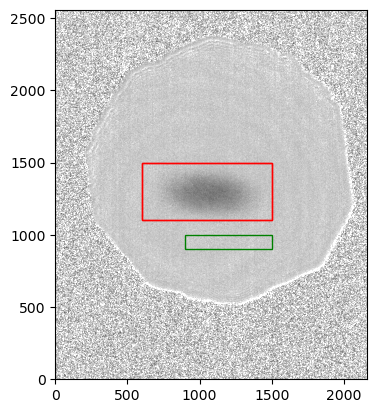

Displaying image: 
/Users/huanbui/Desktop/sample_data/hf/1245535_2023-02-08--11-06-25_TopB.fits

Frame type: FakeOD


In [202]:
# ROI Box and norm_box for ODT HF
# Li HF ROI Box (ODT):
Li_HF_ODT_X_min = 600
Li_HF_ODT_X_max = 1500
Li_HF_ODT_Y_min = 1100
Li_HF_ODT_Y_max = 1500
ROI_ODT_HF = [Li_HF_ODT_X_min, Li_HF_ODT_X_max, Li_HF_ODT_Y_min, Li_HF_ODT_Y_max]

# Li HF Norm Box (ODT):
Li_HF_ODT_X_min_norm = 900
Li_HF_ODT_X_max_norm = 1500
Li_HF_ODT_Y_min_norm = 900
Li_HF_ODT_Y_max_norm = 1000
norm_box_ODT_HF = [Li_HF_ODT_X_min_norm, Li_HF_ODT_X_max_norm, Li_HF_ODT_Y_min_norm, Li_HF_ODT_Y_max_norm]

# display Li LF image:
frame_type_ODT_HF = 'FakeOD'
current_file_fullpath_ODT_HF = construct_file_fullpath(folder_path_ODT_HF, run_id='')
fig, ax = display_image(current_file_fullpath_ODT_HF, ROI_ODT_HF, norm_box_ODT_HF, frame_type_ODT_HF)

#################################################
print('Displaying image: ')
print(current_file_fullpath_ODT_HF)
print('')
print('Frame type: ' + frame_type_ODT_HF)

## <font color=#399FD5>Li ODT HF resonance imaging</font>

Progress: 1/38
Progress: 2/38
Progress: 3/38
Progress: 4/38
Progress: 5/38
Progress: 6/38
Progress: 7/38
Progress: 8/38
Progress: 9/38
Progress: 10/38
Progress: 11/38
Progress: 12/38
Progress: 13/38
Progress: 14/38
Progress: 15/38
Progress: 16/38
Progress: 17/38
Progress: 18/38
Progress: 19/38
Progress: 20/38
Progress: 21/38
Progress: 22/38
Progress: 23/38
Progress: 24/38
Progress: 25/38
Progress: 26/38
Progress: 27/38
Progress: 28/38
Progress: 29/38
Progress: 30/38
Progress: 31/38
Progress: 32/38
Progress: 33/38
Progress: 34/38
Progress: 35/38
Progress: 36/38
Progress: 37/38
Progress: 38/38


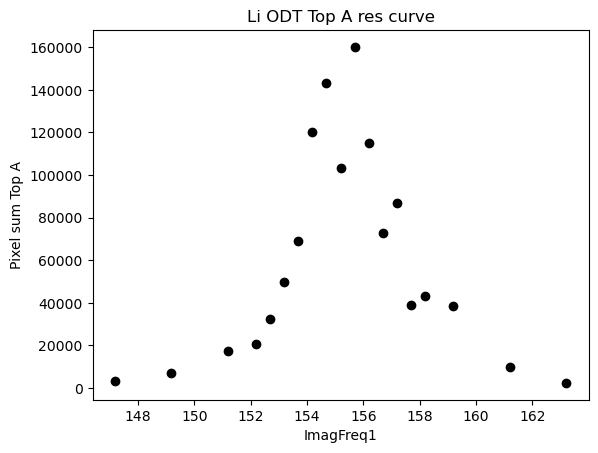

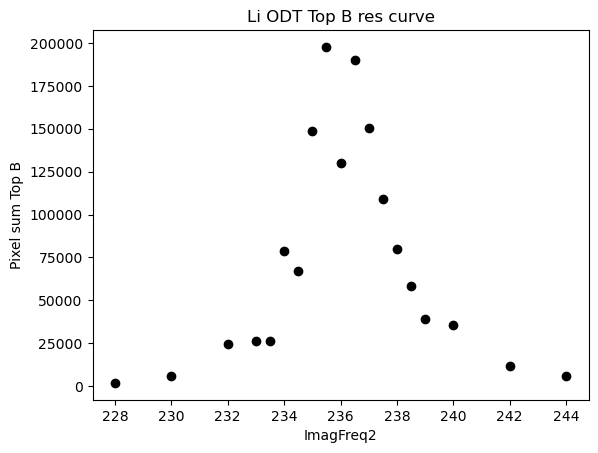

In [203]:
# get pixel sum in ROI for entire folder:
pixel_sums_A, FreqsA, pixel_sums_B, FreqsB = get_pixel_sums_folder_TopAB(folder_path_ODT_HF, 
                                                                        ROI_ODT_HF, 
                                                                        norm_box_ODT_HF, 
                                                                       param_A = 'ImagFreq1', param_B = 'ImagFreq2')

# plot pixel sums versus FreqsA
plt.scatter(FreqsA, pixel_sums_A, color='black')
plt.xlabel('ImagFreq1')
plt.ylabel('Pixel sum Top A')
plt.title('Li ODT Top A res curve')
plt.show()

# plot pixel sums versus FreqsA
plt.scatter(FreqsB, pixel_sums_B, color='black')
plt.xlabel('ImagFreq2')
plt.ylabel('Pixel sum Top B')
plt.title('Li ODT Top B res curve')
plt.show()

## <font color=#399FD5>Li ODT HF resonance curve fitting</font>

----------Fit result----------------
Amplitude: 145425.24 +/- 12168.73
Center: -310.67 +/- 0.25
Gamma prime: 7.22 +/- 1.17
Offset: 19788.35 +/- 9661.77
Calculated saturation parameter: 0.51
------------------------------------
Set value in Cicero to: 155.34


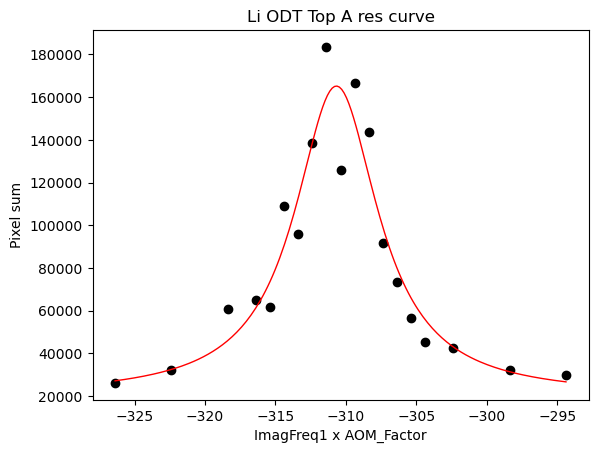

----------Fit result----------------
Amplitude: 188719.88 +/- 15713.89
Center: -472.32 +/- 0.24
Gamma prime: 6.98 +/- 1.13
Offset: 21665.05 +/- 12192.52
Calculated saturation parameter: 0.41
------------------------------------
Set value in Cicero to: 236.16


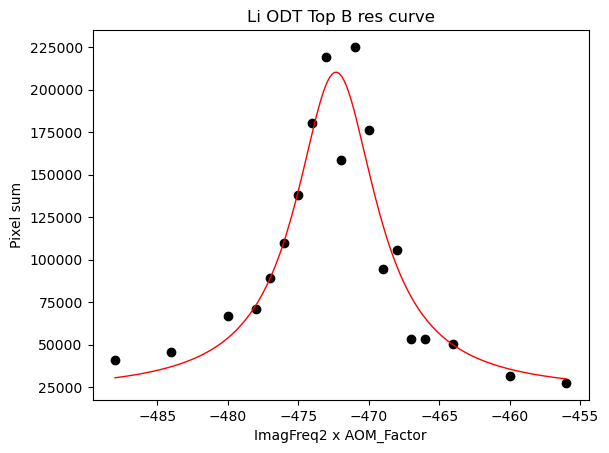

In [27]:
# ODT Top: 
center_guess_A = experiment_parameters_dict_ODT_HF['Values']['state_1_unitarity_res_freq_MHz']
center_guess_B = experiment_parameters_dict_ODT_HF['Values']['state_3_unitarity_res_freq_MHz']
AOM_factor = experiment_parameters_dict_ODT_HF['Values']['li_hf_freq_multiplier']

# Top A
fit_result_TopA = Li_resonance_imaging_curve_fit(FreqsA, 
                               pixel_sums_A, 
                               AOM_factor,
                               center_guess_A,       
                               plot_xlabel = 'ImagFreq1 x AOM_Factor',
                               plot_title = 'Li ODT Top A res curve')

# Top B
fit_result_TopB = Li_resonance_imaging_curve_fit(FreqsB, 
                               pixel_sums_B, 
                               AOM_factor,
                               center_guess_B,
                               plot_xlabel = 'ImagFreq2 x AOM_Factor',
                               plot_title = 'Li ODT Top B res curve')

#print(fit_result_TopA)
#print(fit_result_TopB)

## <font color=#399FD5>Li ODT HF atom counting</font>

Progress: 1/38
Progress: 2/38
Progress: 3/38
Progress: 4/38
Progress: 5/38
Progress: 6/38
Progress: 7/38
Progress: 8/38
Progress: 9/38
Progress: 10/38
Progress: 11/38
Progress: 12/38
Progress: 13/38
Progress: 14/38
Progress: 15/38
Progress: 16/38
Progress: 17/38
Progress: 18/38
Progress: 19/38
Progress: 20/38
Progress: 21/38
Progress: 22/38
Progress: 23/38
Progress: 24/38
Progress: 25/38
Progress: 26/38
Progress: 27/38
Progress: 28/38
Progress: 29/38
Progress: 30/38
Progress: 31/38
Progress: 32/38
Progress: 33/38
Progress: 34/38
Progress: 35/38
Progress: 36/38
Progress: 37/38
Progress: 38/38


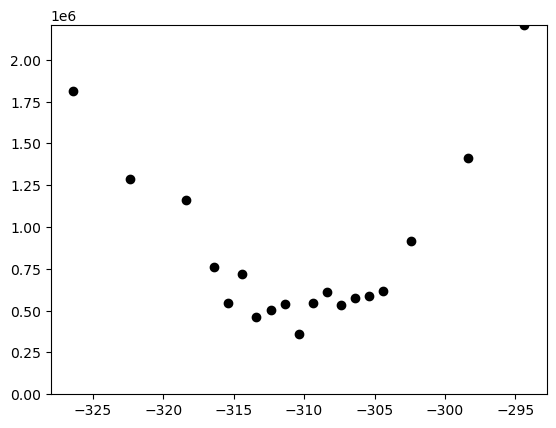

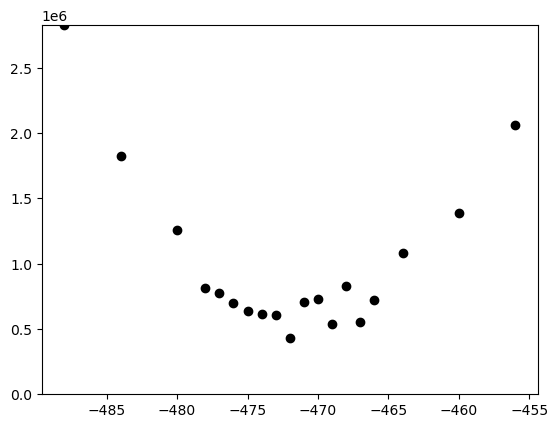

In [39]:
# get imaging parameters here after the fit
omega0_ODT_HF_A = fit_result_TopA['center']
omega0_ODT_HF_B = fit_result_TopB['center']

saturation_parameter_ODT_HF_A = fit_result_TopA['calculated saturation parameter']
saturation_parameter_ODT_HF_B = fit_result_TopB['calculated saturation parameter']

AOM_factor_ODT_HF = experiment_parameters_dict_ODT_HF["Values"]['li_hf_freq_multiplier']

# get pixel area for LF imaging
pixel_size_ODT_HF = experiment_parameters_dict_ODT_HF['Values']['top_um_per_pixel'] # in um^2

# get densities
n2d_list_ODT_HF_A, Freqs_A, n2d_list_ODT_HF_B, Freqs_B, a, b = get_densities_abs_folder_TopAB(folder_path_ODT_HF, 
                                                            ROI_ODT_HF, 
                                                            norm_box_ODT_HF, 
                                                            s_A = saturation_parameter_ODT_HF_A, 
                                                            s_B = saturation_parameter_ODT_HF_B, 
                                                            sigma0 = Li6D2sigma0, 
                                                            img_freq_A = 'ImagFreq1', 
                                                            img_freq_B = 'ImagFreq2', 
                                                            omega0_A = omega0_ODT_HF_A, 
                                                            omega0_B = omega0_ODT_HF_B, 
                                                            gamma = Li6D2Gamma, 
                                                            AOM_factor = AOM_factor_ODT_HF)

# get counts:
atom_counts_ODT_HF_A = []
atom_counts_ODT_HF_B = []
for n2d in n2d_list_ODT_HF_A:
    atom_counts_ODT_HF_A.append(sum(sum(n2d)) * (pixel_size_ODT_HF**2) * 10**(-12))
for n2d in n2d_list_ODT_HF_B:
    atom_counts_ODT_HF_B.append(sum(sum(n2d)) * (pixel_size_ODT_HF**2) * 10**(-12))

# things get funny near saturation...
plt.scatter(Freqs_A, atom_counts_ODT_HF_A, color = 'black')
plt.ylim([0, max(atom_counts_ODT_HF_A)])
plt.show()

plt.scatter(Freqs_B, atom_counts_ODT_HF_B, color = 'black')
plt.ylim([0, max(atom_counts_ODT_HF_B)])
plt.show()

#### COMMENTS ####
# notice the dip? That's due to saturation.
# Corrections have been applied to take saturation into account but it is still not perfect

# Li HF Top Polarization Rotation

# RF Spectroscopy

## <font color=#399FD5>Data preview and preparation</font>

In [241]:
# select folder
folder_path_RF_spec = filedialog.askdirectory()
print('Current folder: ' + folder_path_RF_spec)

# load metadata if avalable:
metadata_fullpath_RF_spec = folder_path_RF_spec + "/run_params_dump.json"
if os.path.isfile(metadata_fullpath_RF_spec):
    with open(metadata_fullpath_RF_spec, 'r') as json_file:
        metadata_dict_RF_spec = json.load(json_file)  
        
# load experiment_parameters if avaiable:
experiment_parameters_fullpath_RF_spec = folder_path_RF_spec + "/experiment_parameters.json"
if os.path.isfile(experiment_parameters_fullpath_RF_spec):
    with open(experiment_parameters_fullpath_RF_spec, 'r') as json_file:
        experiment_parameters_dict_RF_spec = json.load(json_file)  

2023-02-13 16:17:13.664 python[21983:14311287] +[CATransaction synchronize] called within transaction
2023-02-13 16:17:13.670 python[21983:14311287] +[CATransaction synchronize] called within transaction
2023-02-13 16:17:15.412 python[21983:14311287] +[CATransaction synchronize] called within transaction


Current folder: /Users/huanbui/Desktop/sample_data/rf12_spect


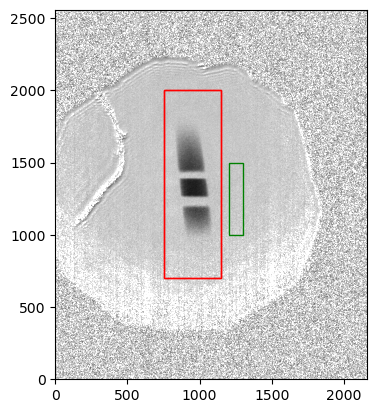

Displaying image: 
/Users/huanbui/Desktop/sample_data/rf12_spect/1138282_2022-09-26--16-17-54_TopB.fits

Frame type: FakeOD


In [242]:
# ROI Box and norm_box for RF spec
# Li RF spec ROI Box:
Li_RF_spec_X_min = 750
Li_RF_spec_X_max = 1150
Li_RF_spec_Y_min = 700
Li_RF_spec_Y_max = 2000
ROI_Li_RF_spec = [Li_RF_spec_X_min, Li_RF_spec_X_max, Li_RF_spec_Y_min, Li_RF_spec_Y_max]

# Li RF spec Norm Box:
Li_RF_spec_X_min_norm = 1200
Li_RF_spec_X_max_norm = 1300
Li_RF_spec_Y_min_norm = 1000
Li_RF_spec_Y_max_norm = 1500
norm_box_Li_RF_spec = [Li_RF_spec_X_min_norm, Li_RF_spec_X_max_norm, Li_RF_spec_Y_min_norm, Li_RF_spec_Y_max_norm]

# display Li RF spec image:
frame_type_Li_RF_spec = 'FakeOD'
current_file_fullpath_Li_RF_spec = construct_file_fullpath(folder_path_RF_spec, run_id='')
fig_RF_spec, ax_RF_spec = display_image(current_file_fullpath_Li_RF_spec, ROI_Li_RF_spec, norm_box_Li_RF_spec, frame_type_Li_RF_spec)

#################################################
print('Displaying image: ')
print(current_file_fullpath_Li_RF_spec)
print('')
print('Frame type: ' + frame_type_Li_RF_spec)

## <font color=#399FD5>Li RF transfer from pixel sum</font>

Progress: 1/82
Progress: 2/82
Progress: 3/82
Progress: 4/82
Progress: 5/82
Progress: 6/82
Progress: 7/82
Progress: 8/82
Progress: 9/82
Progress: 10/82
Progress: 11/82
Progress: 12/82
Progress: 13/82
Progress: 14/82
Progress: 15/82
Progress: 16/82
Progress: 17/82
Progress: 18/82
Progress: 19/82
Progress: 20/82
Progress: 21/82
Progress: 22/82
Progress: 23/82
Progress: 24/82
Progress: 25/82
Progress: 26/82
Progress: 27/82
Progress: 28/82
Progress: 29/82
Progress: 30/82
Progress: 31/82
Progress: 32/82
Progress: 33/82
Progress: 34/82
Progress: 35/82
Progress: 36/82
Progress: 37/82
Progress: 38/82
Progress: 39/82
Progress: 40/82
Progress: 41/82
Progress: 42/82
Progress: 43/82
Progress: 44/82
Progress: 45/82
Progress: 46/82
Progress: 47/82
Progress: 48/82
Progress: 49/82
Progress: 50/82
Progress: 51/82
Progress: 52/82
Progress: 53/82
Progress: 54/82
Progress: 55/82
Progress: 56/82
Progress: 57/82
Progress: 58/82
Progress: 59/82
Progress: 60/82
Progress: 61/82
Progress: 62/82
Progress: 63/82
P

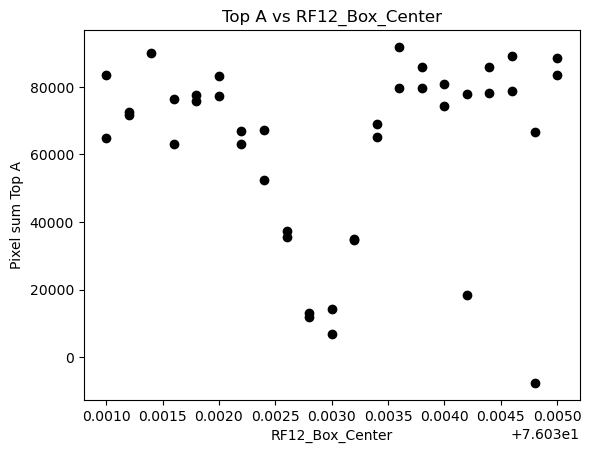

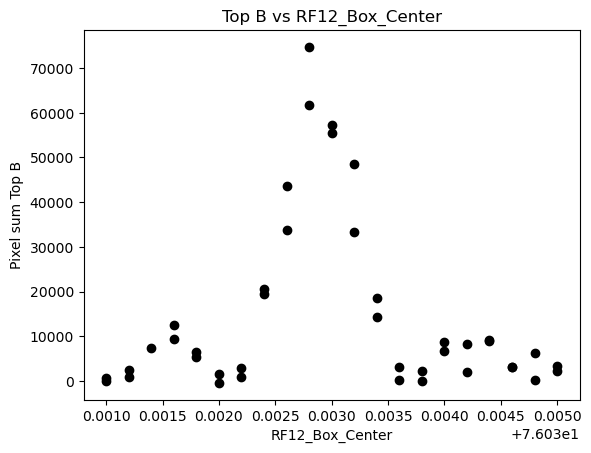

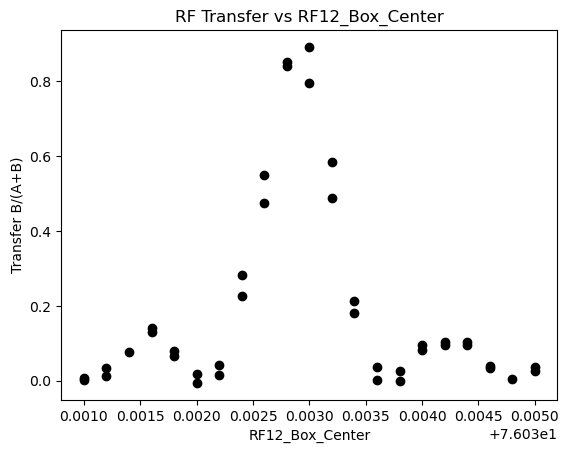

In [265]:
# get pixel sum in ROI for entire folder:
pixel_sums_A_RF, RF_freqs_A, pixel_sums_B_RF, RF_freqs_B = get_pixel_sums_folder_TopAB(folder_path_RF_spec, 
                                                                        ROI_Li_RF_spec, 
                                                                        norm_box_Li_RF_spec, 
                                                                       param_A = 'RF12_Box_Center', param_B = 'RF12_Box_Center')

RF_transfer_pixel_sum = pixel_sums_B_RF/(pixel_sums_A_RF + pixel_sums_B_RF)

# plot pixel sums versus FreqsA
plt.scatter(RF_freqs_A, pixel_sums_A_RF, color='black')
plt.xlabel('RF12_Box_Center')
plt.ylabel('Pixel sum Top A')
plt.title('Top A vs RF12_Box_Center')
plt.show()

# plot pixel sums versus FreqsA
plt.scatter(RF_freqs_B, pixel_sums_B_RF, color='black')
plt.xlabel('RF12_Box_Center')
plt.ylabel('Pixel sum Top B')
plt.title('Top B vs RF12_Box_Center')
plt.show()

# filter data:
filtered_RF_freqs_A, filtered_RF_transfer_pixel_sum = generic_data_filter(RF_freqs_A, RF_transfer_pixel_sum,2)

# plot transfer, using pixel sums:
plt.scatter(filtered_RF_freqs_A, filtered_RF_transfer_pixel_sum, color='black')
plt.xlabel('RF12_Box_Center')
plt.ylabel('Transfer B/(A+B)')
plt.title('RF Transfer vs RF12_Box_Center')
plt.show()

## <font color=#399FD5>Li RF transfer from atom count</font>

Progress: 1/34
Progress: 2/34
Progress: 3/34
Progress: 4/34
Progress: 5/34
Progress: 6/34
Progress: 7/34
Progress: 8/34
Progress: 9/34
Progress: 10/34
Progress: 11/34
Progress: 12/34
Progress: 13/34
Progress: 14/34
Progress: 15/34
Progress: 16/34
Progress: 17/34
Progress: 18/34
Progress: 19/34
Progress: 20/34
Progress: 21/34
Progress: 22/34
Progress: 23/34
Progress: 24/34
Progress: 25/34
Progress: 26/34
Progress: 27/34
Progress: 28/34
Progress: 29/34
Progress: 30/34
Progress: 31/34
Progress: 32/34
Progress: 33/34
Progress: 34/34


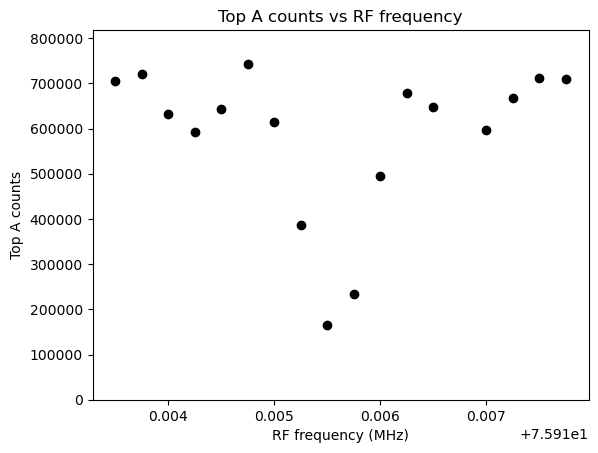

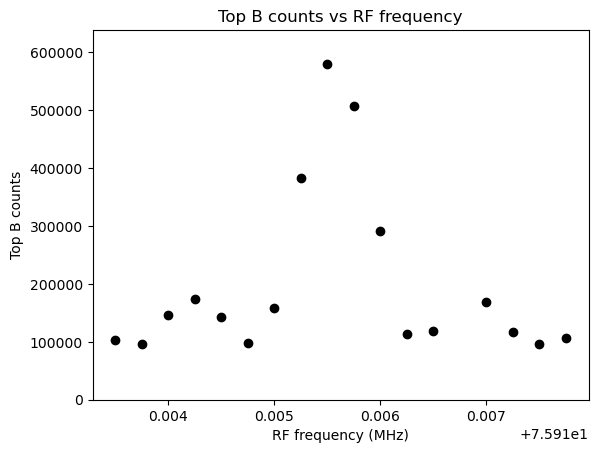

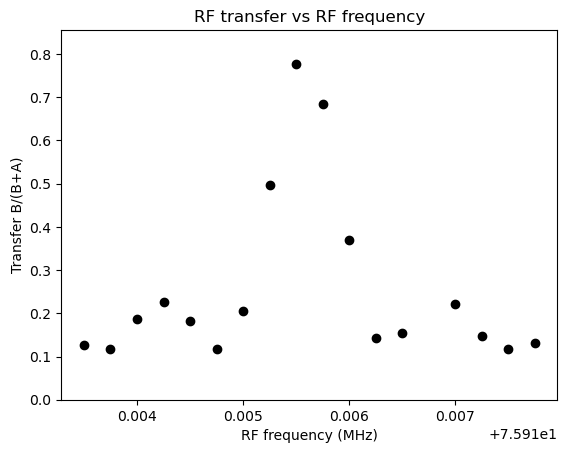

In [53]:
# get imaging parameters here
AOM_factor_RF_spec = experiment_parameters_dict_RF_spec["Values"]['li_hf_freq_multiplier']
omega0_RF_spec_A = experiment_parameters_dict_RF_spec["Values"]['state_1_unitarity_res_freq_MHz']
omega0_RF_spec_B = experiment_parameters_dict_RF_spec["Values"]['state_2_unitarity_res_freq_MHz']
omega0_RF_spec_A = omega0_RF_spec_A*AOM_factor_RF_spec
omega0_RF_spec_B = omega0_RF_spec_B*AOM_factor_RF_spec

saturation_parameter_RF_spec_A = 0 # unknown, so assume 0
saturation_parameter_RF_spec_B = 0 # unknown, so assume 0


# get pixel area for LF imaging
pixel_size_RF_spec = experiment_parameters_dict_RF_spec['Values']['top_um_per_pixel'] # in um^2

# get densities
n2ds_RF_spec_A, img_freqs_A, n2ds_RF_spec_B, img_freqs_B, RF_A, RF_B = get_densities_abs_folder_TopAB(folder_path_RF_spec, 
                                                            ROI_Li_RF_spec, 
                                                            norm_box_Li_RF_spec, 
                                                            s_A = saturation_parameter_RF_spec_A, 
                                                            s_B = saturation_parameter_RF_spec_B, 
                                                            sigma0 = Li6D2sigma0, 
                                                            img_freq_A = 'ImagFreq1', 
                                                            img_freq_B = 'ImagFreq2', 
                                                            omega0_A = omega0_RF_spec_A, 
                                                            omega0_B = omega0_RF_spec_B, 
                                                            gamma = Li6D2Gamma, 
                                                            AOM_factor = AOM_factor_RF_spec, 
                                                            param_A = 'RF12_Box_Center',
                                                            param_B = 'RF12_Box_Center')

# get counts:
atom_counts_RF_spec_A = []
atom_counts_RF_spec_B = []
for n2d in n2ds_RF_spec_A:
    atom_counts_RF_spec_A.append(sum(sum(n2d)) * (pixel_size_RF_spec**2) * 10**(-12))
for n2d in n2ds_RF_spec_B:
    atom_counts_RF_spec_B.append(sum(sum(n2d)) * (pixel_size_RF_spec**2) * 10**(-12))
    
# get RF transfer from counts:
atom_counts_RF_spec_A = np.array(atom_counts_RF_spec_A)
atom_counts_RF_spec_B = np.array(atom_counts_RF_spec_B)
RF_transfer_counts = atom_counts_RF_spec_B / (atom_counts_RF_spec_A + atom_counts_RF_spec_B)

# atom counts vs RF freq
plt.scatter(RF_A, atom_counts_RF_spec_A, color = 'black')
plt.ylim([0, 1.1 * max(atom_counts_RF_spec_A)])
plt.title('Top A counts vs RF frequency')
plt.xlabel('RF frequency (MHz)')
plt.ylabel('Top A counts')
plt.show()

plt.scatter(RF_B, atom_counts_RF_spec_B, color = 'black')
plt.ylim([0, 1.1 * max(atom_counts_RF_spec_B)])
plt.title('Top B counts vs RF frequency')
plt.xlabel('RF frequency (MHz)')
plt.ylabel('Top B counts')
plt.show()

# plot RF transfer from atom counts:
plt.scatter(RF_A, RF_transfer_counts, color = 'black')
plt.ylim([0, 1.1 * max(RF_transfer_counts)])
plt.title('RF transfer vs RF frequency')
plt.xlabel('RF frequency (MHz)')
plt.ylabel('Transfer B/(B+A)')
plt.show()


## <font color=#399FD5>Li RF resonance curve fitting</font>

Some theory for this: The exact solution to the Rabi problem (without assuming spontaneous decay) is given by 

$P_2(\tau) = \frac{\omega_R^2}{\omega_R^2 + \delta^2} \sin^2\left( \tau  \frac{\sqrt{\delta^2 + \omega_R^2} }{2} \right), $ 

where we have assumed that initially $P_1 = 1$. Here $\tau$ is the width of the RF pulse, $\Omega_R$ is the bare Rabi frequency, and $\delta$ is the detuning. The setting in our case is that we know $\tau$ and $\delta$. So, the fit will tell us $\Omega_R$. 



In [269]:
# RF resonance curve fitting
RF_freqs = np.array(filtered_RF_freqs_A) # in MHz --> Hz
omega0_RF_guess = np.average(filtered_RF_freqs_A) # temporary, for now, in MHz
RF_transfers = RF_transfer_counts
# get pulse widths... should all be the same but ok
tau = []
d_old = dict()
for d in get_run_params(folder_path_RF_spec, ['SpectPulseTime', 'id']):
    if d != d_old:                    
        tau.append(d['SpectPulseTime'])
        d_old = d
tau = np.array(tau)
        
        
RF_freqs_and_taus = np.array([RF_freqs, tau])
# Top A
fit_result_RF_spec = Li_P2_Rabi_RF_curve_fit((RF_freqs, tau), 
                                             RF_transfer_pixel_sum, 
                                             omega0_guess = omega0_RF_guess,
                                             omegaR_guess = 0.0005, # MHz 
                                             plot_xlabel = 'RF frequency (MHz)',
                                             plot_title = 'RF Resonance Curve')

print(fit_result_RF_spec)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.